In [25]:
# 导入必要的库
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

In [26]:
# 自定义数据集加载类
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = datasets.ImageFolder(root=root_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

In [27]:
# 数据预处理和加载
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 加载数据集
dataset = CustomDataset(root_dir='flowersData', transform=transform)
print(f'Dataset size: {len(dataset)}')
print(f'Number of classes: {len(dataset.data.classes)}')

Dataset size: 4317
Number of classes: 5


In [28]:
# 划分数据集
train_size = int(0.65 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# 打印数据集大小和形状
print(f'Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}')

Train size: 2806, Val size: 647, Test size: 864


In [29]:
# 定义超参数
learning_rate = 0.001
num_epochs = 66
batch_size = 128
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use device: ", device)

Use device:  cuda


In [30]:
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for images, labels in train_loader:
    print(f'Batch shape: {images.shape}, Labels shape: {labels.shape}')
    break  # Only print the shape of the first batch


Batch shape: torch.Size([128, 3, 224, 224]), Labels shape: torch.Size([128])


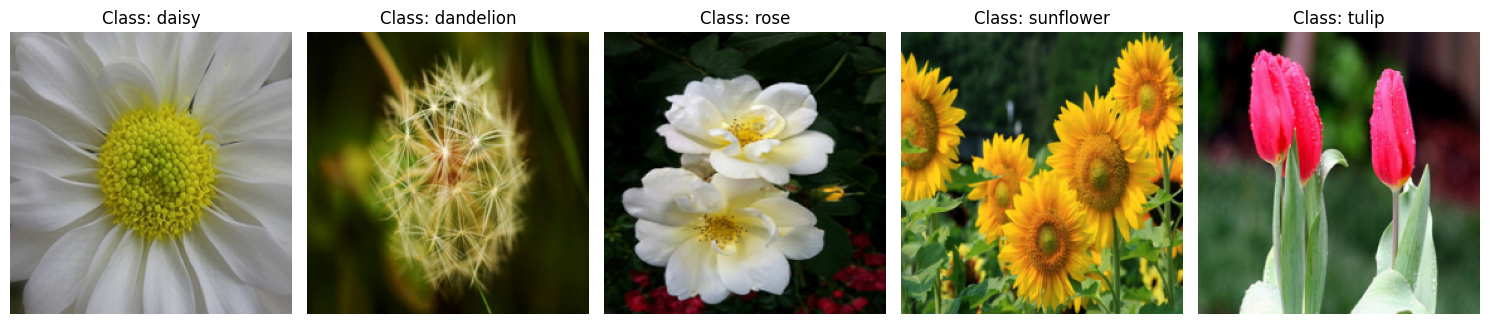

In [31]:
# 获取每个类别的样本
class_samples = {}
for img, label in dataset.data:
    if label not in class_samples:
        class_samples[label] = img

# 可视化样本
fig, axes = plt.subplots(1, len(class_samples), figsize=(15, 5))
for ax, (label, img) in zip(axes, class_samples.items()):
    # 反向归一化
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    ax.imshow(img.permute(1, 2, 0).clamp(0, 1))  # 转换为HWC格式并限制范围
    ax.set_title(f'Class: {dataset.data.classes[label]}')  # 显示类别名称
    ax.axis('off')

plt.tight_layout()
plt.show()

In [32]:
# 构建CNN模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  
        self.bn5 = nn.BatchNorm2d(256)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability
        
        # Recalculate the input size for the fully connected layer
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # 224 -> 112 -> 56 -> 28 -> 14
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(dataset.data.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x)))) 
        x = x.view(-1, 256 * 7 * 7)  # 更新 view 尺寸
        x = self.dropout(F.relu(self.fc1(x)))  # Dropout after fc1
        x = self.dropout(F.relu(self.fc2(x)))  # Dropout after fc2
        x = self.fc3(x)
        return x

In [33]:
# 初始化模型、损失函数和优化器
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
       BatchNorm2d-5         [-1, 32, 112, 112]              64
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
       BatchNorm2d-8           [-1, 64, 56, 56]             128
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]          73,856
      BatchNorm2d-11          [-1, 128, 28, 28]             256
        MaxPool2d-12          [-1, 128, 14, 14]               0
           Conv2d-13          [-1, 256, 14, 14]         295,168
      BatchNorm2d-14          [-1, 256,

In [34]:
# TensorBoard设置
writer = SummaryWriter('runs/flower_experiment')

# 训练模型
for epoch in range(num_epochs):
    since = time.time()
    model.train()
    train_loss = 0
    train_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 记录每个批次的损失和准确率
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        writer.add_scalar('loss/train', loss.item(), epoch * len(train_loader) + i)
        writer.add_scalar('accuracy/train', (predicted == labels).sum().item() / labels.size(0), epoch * len(train_loader) + i)

    # 计算训练集的平均损失和准确率
    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_dataset)


    # 验证模型
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            writer.add_scalar('loss/validation', loss.item(), epoch * len(val_loader) + i)
            writer.add_scalar('accuracy/validation', (predicted == labels).sum().item() / labels.size(0), epoch * len(val_loader) + i)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_dataset)
    
    writer.add_scalars('loss', {"train_loss": train_loss,"val_loss": val_loss}, epoch)
    writer.add_scalars('accuracy', {"train_accuracy": train_accuracy, "val_accuracy": val_accuracy}, epoch)

    # 打印每轮训练的日志
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Time: {time.time()-since:.3f}s')

# 保存模型
torch.save(model.state_dict(), 'cnn_flower_model.pth')
# 关闭TensorBoard
writer.close()

Epoch [1/66], Train Loss: 1.7583, Train Accuracy: 0.3614, Validation Loss: 1.1897, Validation Accuracy: 0.5085, Time: 12.900s
Epoch [2/66], Train Loss: 1.2632, Train Accuracy: 0.4547, Validation Loss: 1.1038, Validation Accuracy: 0.5502, Time: 12.623s
Epoch [3/66], Train Loss: 1.1679, Train Accuracy: 0.5164, Validation Loss: 1.0189, Validation Accuracy: 0.5966, Time: 11.837s
Epoch [4/66], Train Loss: 1.0853, Train Accuracy: 0.5581, Validation Loss: 0.9752, Validation Accuracy: 0.6136, Time: 11.910s
Epoch [5/66], Train Loss: 1.0255, Train Accuracy: 0.5816, Validation Loss: 0.9173, Validation Accuracy: 0.6368, Time: 12.362s
Epoch [6/66], Train Loss: 0.9518, Train Accuracy: 0.6233, Validation Loss: 0.8490, Validation Accuracy: 0.6754, Time: 11.791s
Epoch [7/66], Train Loss: 0.8755, Train Accuracy: 0.6543, Validation Loss: 0.9450, Validation Accuracy: 0.6491, Time: 11.816s
Epoch [8/66], Train Loss: 0.8499, Train Accuracy: 0.6643, Validation Loss: 0.8394, Validation Accuracy: 0.6801, Time: 

In [40]:
# 测试模型
model.eval()
test_loss = 0
correct = 0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu())
        y_pred.extend(predicted.cpu())

# 打印测试集指标
test_accuracy = correct / len(test_dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')
# 计算并打印精确率、召回率和F1分数
report = classification_report(y_true, y_pred, target_names=dataset.data.classes)
print(report)

Test Accuracy: 0.7685
              precision    recall  f1-score   support

       daisy       0.91      0.73      0.81       144
   dandelion       0.87      0.76      0.81       216
        rose       0.73      0.61      0.66       156
   sunflower       0.74      0.90      0.81       149
       tulip       0.67      0.83      0.74       199

    accuracy                           0.77       864
   macro avg       0.78      0.77      0.77       864
weighted avg       0.78      0.77      0.77       864



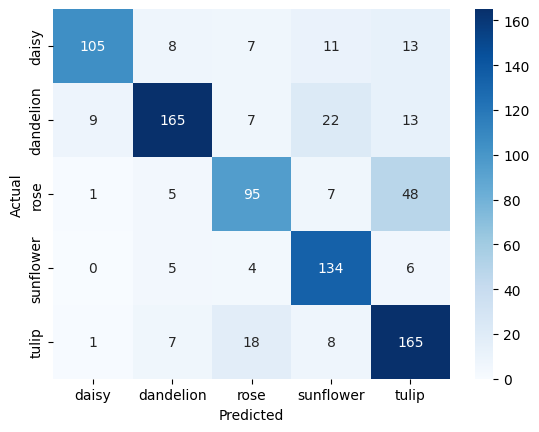

In [39]:
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.data.classes, yticklabels=dataset.data.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()